<a href="https://colab.research.google.com/github/prav1807/vrpAntColonyOptimisation/blob/capacitatedVRP/updatedVRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
''' Manual Adjusment of Parameters Tuning using file uploads ... '''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# ----------------- Flexible File Loading -----------------

def load_file(file_path):

    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)  # Uses Pandas for CSV
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)  # Uses Pandas for Excel
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)  # Uses Pandas for JSON
    elif file_path.endswith('.vrp'):
        return load_vrp_data(file_path)  # Uses custom parser for VRP
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

# ----------------- Custom VRP Parser -----------------

def load_vrp_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    coordinates = {}
    demands = {}
    depot = None
    vehicle_capacity = None

    node_section = False
    demand_section = False
    depot_section = False

    for line in lines:
        line = line.strip()

        if line.startswith("CAPACITY"):
            vehicle_capacity = int(line.split()[-1])
        elif line.startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        elif line.startswith("DEMAND_SECTION"):
            node_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            demand_section = False
            depot_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            x, y = float(parts[1]), float(parts[2])
            coordinates[customer_id] = (x, y)

        if demand_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            demand = int(parts[1])
            demands[customer_id] = demand

        if depot_section:
            depot_id = int(line)
            if depot_id != -1:
                depot = depot_id - 1  # Convert to 0-based index

    return coordinates, demands, depot, vehicle_capacity

# ----------------- Problem Definition -----------------

# Load the dataset (can handle CSV, Excel, JSON, or VRP files)
file_path = '/content/sample_data/A-n32-k5.vrp'
data = load_file(file_path)

# If using a VRP file, it returns the necessary components
if isinstance(data, tuple):
    customers, demands, depot, vehicle_capacity = data
else:
    raise ValueError("Currently, only VRP file handling is implemented.")

# ----------------- ACO Parameters -----------------

num_ants = 30          # Number of ants per iteration
num_iterations = 100   # Number of iterations
alpha = 0.5            # Pheromone influence
beta = 2.0             # Distance influence
evaporation_rate = 0.3 # Pheromone evaporation rate
pheromone_constant = 50  # Pheromone deposit factor
num_vehicles = 5       # Number of vehicles based on dataset

# ----------------- Distance Calculation -----------------

# Calculate distance matrix
def calculate_distance_matrix(customers):
    num_customers = len(customers)
    distance_matrix = np.zeros((num_customers, num_customers))
    for i in customers:
        for j in customers:
            if i != j:
                xi, yi = customers[i]
                xj, yj = customers[j]
                distance = np.sqrt((xi - xj)**2 + (yi - yj)**2)
                distance_matrix[i][j] = distance
            else:
                distance_matrix[i][j] = 0
    return distance_matrix

distance_matrix = calculate_distance_matrix(customers)

# Initialize pheromone matrix
num_customers = len(customers)
pheromone_matrix = np.ones((num_customers, num_customers))  # Initial pheromone

# ----------------- ACO Functions -----------------

def probability_of_next_node(pheromone, distance, alpha, beta):
    if distance == 0:
        return 0
    return (pheromone ** alpha) * ((1.0 / distance) ** beta)

def construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles):
    routes = []
    for _ in range(num_vehicles):
        route = [depot]  # Start from depot
        vehicle_load = 0
        visited = set([depot])

        while True:
            current_node = route[-1]
            probabilities = []
            candidates = []
            for customer in customers:
                if customer not in visited and demands[customer] + vehicle_load <= vehicle_capacity:
                    candidates.append(customer)
                    prob = probability_of_next_node(
                        pheromone_matrix[current_node][customer],
                        distance_matrix[current_node][customer],
                        alpha,
                        beta
                    )
                    probabilities.append(prob)

            if not candidates:
                # No more customers can be added to this route
                route.append(depot)  # Return to depot
                break

            # Normalize probabilities
            total = sum(probabilities)
            if total == 0:
                # Avoid division by zero
                probabilities = [1/len(probabilities)] * len(probabilities)
            else:
                probabilities = [p / total for p in probabilities]

            # Select next customer based on probability distribution
            next_customer = random.choices(candidates, weights=probabilities, k=1)[0]
            route.append(next_customer)
            vehicle_load += demands[next_customer]
            visited.add(next_customer)

        routes.append(route)

    # Check if all customers are visited
    all_visited = True
    for customer in customers:
        if customer not in [c for route in routes for c in route]:
            all_visited = False
            break

    if not all_visited:
        # If not all customers are visited, assign remaining to any vehicle that can take them
        for customer in customers:
            if customer not in [c for route in routes for c in route]:
                for route in routes:
                    # Check capacity
                    current_load = sum([demands[c] for c in route if c != depot])
                    if current_load + demands[customer] <= vehicle_capacity:
                        # Insert before returning to depot
                        route.insert(-1, customer)
                        break

    return routes

def calculate_route_length(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

def update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant):
    # Evaporate pheromones
    pheromone_matrix *= (1 - evaporation_rate)

    # Add pheromones based on solutions
    for routes in ants_solutions:
        total_distance = 0
        for route in routes:
            total_distance += calculate_route_length(route, distance_matrix)
        pheromone_deposit = pheromone_constant / total_distance

        for route in routes:
            for i in range(len(route) - 1):
                pheromone_matrix[route[i]][route[i+1]] += pheromone_deposit
                pheromone_matrix[route[i+1]][route[i]] += pheromone_deposit  # Symmetric

# ----------------------- Visualising the Customer and Depot ----------------
def plot_customers(customers, routes=None):
    plt.figure(figsize=(10, 8))
    for customer, (x, y) in customers.items():
        if customer == depot:
            plt.scatter(x, y, c='red', marker='s', s=100, label='Depot')
            plt.text(x + 1, y + 1, f'Depot ({customer})')
        else:
            plt.scatter(x, y, c='blue', marker='o', s=50)
            plt.text(x + 1, y + 1, f'{customer}')

    if routes:
        colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray']
        for idx, route in enumerate(routes):
            route_coords = [customers[customer] for customer in route]
            xs, ys = zip(*route_coords)
            plt.plot(xs, ys, color=colors[idx % len(colors)], label=f'Vehicle {idx+1}')

    plt.title('Customer Locations and Depot')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------- ACO Algorithm -----------------

best_routes = None
best_distance = float('inf')

for iteration in range(num_iterations):
    ants_solutions = []
    iteration_best_distance = float('inf')
    iteration_best_routes = None

    for _ in range(num_ants):
        solution = construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles)
        ants_solutions.append(solution)

        # Calculate total distance
        total_distance = sum([calculate_route_length(route, distance_matrix) for route in solution])

        # Update best solution
        if total_distance < best_distance:
            best_distance = total_distance
            best_routes = solution

        # Track the best solution in this iteration
        if total_distance < iteration_best_distance:
            iteration_best_distance = total_distance
            iteration_best_routes = solution

    # Update pheromones based on all ants' solutions
    update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant)

    # Optional: Print iteration details
    print(f"Iteration {iteration+1}: Best Distance = {iteration_best_distance:.2f}")

# ----------------- Results -----------------

print("\nBest Route Found:")
total_distance = 0
for idx, route in enumerate(best_routes):
    print(f"Vehicle {idx+1}: {route}")
    route_distance = calculate_route_length(route, distance_matrix)
    print(f"  Distance: {route_distance:.2f}")
    total_distance += route_distance
print(f"Total Distance: {total_distance:.2f}")

# Plot the best routes
plot_customers(customers, best_routes)


In [ ]:
''' Performing Parameter Tuning using Grid Search '''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product

# ----------------- Flexible File Loading -----------------

def load_file(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)  # Uses Pandas for CSV
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)  # Uses Pandas for Excel
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)  # Uses Pandas for JSON
    elif file_path.endswith('.vrp'):
        return load_vrp_data(file_path)  # Uses custom parser for VRP
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

# ----------------- Custom VRP Parser -----------------

def load_vrp_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    coordinates = {}
    demands = {}
    depot = None
    vehicle_capacity = None

    node_section = False
    demand_section = False
    depot_section = False

    for line in lines:
        line = line.strip()

        if line.startswith("CAPACITY"):
            vehicle_capacity = int(line.split()[-1])
        elif line.startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        elif line.startswith("DEMAND_SECTION"):
            node_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            demand_section = False
            depot_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            x, y = float(parts[1]), float(parts[2])
            coordinates[customer_id] = (x, y)

        if demand_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            demand = int(parts[1])
            demands[customer_id] = demand

        if depot_section:
            depot_id = int(line)
            if depot_id != -1:
                depot = depot_id - 1  # Convert to 0-based index

    return coordinates, demands, depot, vehicle_capacity

# ----------------- Problem Definition -----------------

# Load the dataset (can handle CSV, Excel, JSON, or VRP files)
file_path = '/content/sample_data/A-n32-k5.vrp'
data = load_file(file_path)

# If using a VRP file, it returns the necessary components
if isinstance(data, tuple):
    customers, demands, depot, vehicle_capacity = data
else:
    raise ValueError("Currently, only VRP file handling is implemented.")

# ----------------- ACO Functions -----------------

def probability_of_next_node(pheromone, distance, alpha, beta):
    if distance == 0:
        return 0
    return (pheromone ** alpha) * ((1.0 / distance) ** beta)

def construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles):
    routes = []
    for _ in range(num_vehicles):
        route = [depot]  # Start from depot
        vehicle_load = 0
        visited = set([depot])

        while True:
            current_node = route[-1]
            probabilities = []
            candidates = []
            for customer in customers:
                if customer not in visited and demands[customer] + vehicle_load <= vehicle_capacity:
                    candidates.append(customer)
                    prob = probability_of_next_node(
                        pheromone_matrix[current_node][customer],
                        distance_matrix[current_node][customer],
                        alpha,
                        beta
                    )
                    probabilities.append(prob)

            if not candidates:
                # No more customers can be added to this route
                route.append(depot)  # Return to depot
                break

            # Normalize probabilities
            total = sum(probabilities)
            if total == 0:
                # Avoid division by zero
                probabilities = [1/len(probabilities)] * len(probabilities)
            else:
                probabilities = [p / total for p in probabilities]

            # Select next customer based on probability distribution
            next_customer = random.choices(candidates, weights=probabilities, k=1)[0]
            route.append(next_customer)
            vehicle_load += demands[next_customer]
            visited.add(next_customer)

        routes.append(route)

    # Check if all customers are visited
    all_visited = True
    for customer in customers:
        if customer not in [c for route in routes for c in route]:
            all_visited = False
            break

    if not all_visited:
        # If not all customers are visited, assign remaining to any vehicle that can take them
        for customer in customers:
            if customer not in [c for route in routes for c in route]:
                for route in routes:
                    # Check capacity
                    current_load = sum([demands[c] for c in route if c != depot])
                    if current_load + demands[customer] <= vehicle_capacity:
                        # Insert before returning to depot
                        route.insert(-1, customer)
                        break

    return routes

def calculate_route_length(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

def update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant):
    # Evaporate pheromones
    pheromone_matrix *= (1 - evaporation_rate)

    # Add pheromones based on solutions
    for routes in ants_solutions:
        total_distance = 0
        for route in routes:
            total_distance += calculate_route_length(route, distance_matrix)
        pheromone_deposit = pheromone_constant / total_distance

        for route in routes:
            for i in range(len(route) - 1):
                pheromone_matrix[route[i]][route[i+1]] += pheromone_deposit
                pheromone_matrix[route[i+1]][route[i]] += pheromone_deposit  # Symmetric

# ----------------- Grid Search for Parameter Tuning -----------------

def run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant, num_iterations=100):
    # Initialize pheromone matrix for each run
    num_customers = len(customers)
    pheromone_matrix = np.ones((num_customers, num_customers))  # Initial pheromone

    best_routes = None
    best_distance = float('inf')

    for iteration in range(num_iterations):
        ants_solutions = []
        iteration_best_distance = float('inf')
        iteration_best_routes = None

        for _ in range(num_ants):
            solution = construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles)
            ants_solutions.append(solution)

            # Calculate total distance
            total_distance = sum([calculate_route_length(route, distance_matrix) for route in solution])

            # Update best solution
            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = solution

            # Track the best solution in this iteration
            if total_distance < iteration_best_distance:
                iteration_best_distance = total_distance
                iteration_best_routes = solution

        # Update pheromones based on all ants' solutions
        update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant)

    return best_distance

# Define parameter ranges for grid search
param_grid = {
    'num_ants': [10, 20, 30],
    'alpha': [0.5, 1.0, 2.0],
    'beta': [2.0, 5.0, 10.0],
    'evaporation_rate': [0.1, 0.3, 0.5],
    'pheromone_constant': [50, 100, 150]
}

# Get all combinations of parameters
param_combinations = list(product(param_grid['num_ants'],
                                  param_grid['alpha'],
                                  param_grid['beta'],
                                  param_grid['evaporation_rate'],
                                  param_grid['pheromone_constant']))

# Initialize variables to store the best parameters and results
best_params = None
best_distance = float('inf')

# Run ACO for each combination of parameters
for (num_ants, alpha, beta, evaporation_rate, pheromone_constant) in param_combinations:
    print(f"Testing ACO with: num_ants={num_ants}, alpha={alpha}, beta={beta}, evaporation_rate={evaporation_rate}, pheromone_constant={pheromone_constant}")

    # Run ACO and get the best distance for this parameter set
    distance = run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant)

    # Check if this is the best result so far
    if distance < best_distance:
        best_distance = distance
        best_params = (num_ants, alpha, beta, evaporation_rate, pheromone_constant)

print(f"Best parameters: {best_params}")
print(f"Best total distance: {best_distance}")

# Plot the best routes based on the best parameters
plot_customers(customers, best_routes)


In [ ]:
''' Implemented Random Search for Parameter Tuning '''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# ----------------- Flexible File Loading -----------------

def load_file(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)  # Uses Pandas for CSV
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)  # Uses Pandas for Excel
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)  # Uses Pandas for JSON
    elif file_path.endswith('.vrp'):
        return load_vrp_data(file_path)  # Uses custom parser for VRP
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

# ----------------- Custom VRP Parser -----------------

def load_vrp_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    coordinates = {}
    demands = {}
    depot = None
    vehicle_capacity = None

    node_section = False
    demand_section = False
    depot_section = False

    for line in lines:
        line = line.strip()

        if line.startswith("CAPACITY"):
            vehicle_capacity = int(line.split()[-1])
        elif line.startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        elif line.startswith("DEMAND_SECTION"):
            node_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            demand_section = False
            depot_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            x, y = float(parts[1]), float(parts[2])
            coordinates[customer_id] = (x, y)

        if demand_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            demand = int(parts[1])
            demands[customer_id] = demand

        if depot_section:
            depot_id = int(line)
            if depot_id != -1:
                depot = depot_id - 1  # Convert to 0-based index

    return coordinates, demands, depot, vehicle_capacity

# ----------------- Problem Definition -----------------

# Load the dataset (can handle CSV, Excel, JSON, or VRP files)
file_path = '/content/sample_data/A-n32-k5.vrp'
data = load_file(file_path)

# If using a VRP file, it returns the necessary components
if isinstance(data, tuple):
    customers, demands, depot, vehicle_capacity = data
else:
    raise ValueError("Currently, only VRP file handling is implemented.")

# ----------------- ACO Functions -----------------

def probability_of_next_node(pheromone, distance, alpha, beta):
    if distance == 0:
        return 0
    return (pheromone ** alpha) * ((1.0 / distance) ** beta)

def construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles):
    routes = []
    for _ in range(num_vehicles):
        route = [depot]  # Start from depot
        vehicle_load = 0
        visited = set([depot])

        while True:
            current_node = route[-1]
            probabilities = []
            candidates = []
            for customer in customers:
                if customer not in visited and demands[customer] + vehicle_load <= vehicle_capacity:
                    candidates.append(customer)
                    prob = probability_of_next_node(
                        pheromone_matrix[current_node][customer],
                        distance_matrix[current_node][customer],
                        alpha,
                        beta
                    )
                    probabilities.append(prob)

            if not candidates:
                # No more customers can be added to this route
                route.append(depot)  # Return to depot
                break

            # Normalize probabilities
            total = sum(probabilities)
            if total == 0:
                probabilities = [1/len(probabilities)] * len(probabilities)
            else:
                probabilities = [p / total for p in probabilities]

            # Select next customer based on probability distribution
            next_customer = random.choices(candidates, weights=probabilities, k=1)[0]
            route.append(next_customer)
            vehicle_load += demands[next_customer]
            visited.add(next_customer)

        routes.append(route)

    # Check if all customers are visited
    all_visited = True
    for customer in customers:
        if customer not in [c for route in routes for c in route]:
            all_visited = False
            break

    if not all_visited:
        # If not all customers are visited, assign remaining to any vehicle that can take them
        for customer in customers:
            if customer not in [c for route in routes for c in route]:
                for route in routes:
                    # Check capacity
                    current_load = sum([demands[c] for c in route if c != depot])
                    if current_load + demands[customer] <= vehicle_capacity:
                        route.insert(-1, customer)
                        break

    return routes

def calculate_route_length(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

def update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant):
    # Evaporate pheromones
    pheromone_matrix *= (1 - evaporation_rate)

    # Add pheromones based on solutions
    for routes in ants_solutions:
        total_distance = 0
        for route in routes:
            total_distance += calculate_route_length(route, distance_matrix)
        pheromone_deposit = pheromone_constant / total_distance

        for route in routes:
            for i in range(len(route) - 1):
                pheromone_matrix[route[i]][route[i+1]] += pheromone_deposit
                pheromone_matrix[route[i+1]][route[i]] += pheromone_deposit  # Symmetric

# ----------------- Random Search for Parameter Tuning -----------------

def run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant, num_iterations=100):
    # Initialize pheromone matrix for each run
    num_customers = len(customers)
    pheromone_matrix = np.ones((num_customers, num_customers))  # Initial pheromone

    best_routes = None
    best_distance = float('inf')

    for iteration in range(num_iterations):
        ants_solutions = []
        iteration_best_distance = float('inf')
        iteration_best_routes = None

        for _ in range(num_ants):
            solution = construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles)
            ants_solutions.append(solution)

            # Calculate total distance
            total_distance = sum([calculate_route_length(route, distance_matrix) for route in solution])

            # Update best solution
            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = solution

            # Track the best solution in this iteration
            if total_distance < iteration_best_distance:
                iteration_best_distance = total_distance
                iteration_best_routes = solution

        # Update pheromones based on all ants' solutions
        update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant)

    return best_distance, best_routes

# Define parameter ranges for random search
param_ranges = {
    'num_ants': (10, 50),  # Range of values: min, max
    'alpha': (0.5, 2.0),
    'beta': (1.0, 10.0),
    'evaporation_rate': (0.1, 0.9),
    'pheromone_constant': (50, 150)
}

# Function to sample random parameters within the ranges
def sample_params(param_ranges):
    return {
        'num_ants': random.randint(*param_ranges['num_ants']),
        'alpha': random.uniform(*param_ranges['alpha']),
        'beta': random.uniform(*param_ranges['beta']),
        'evaporation_rate': random.uniform(*param_ranges['evaporation_rate']),
        'pheromone_constant': random.randint(*param_ranges['pheromone_constant'])
    }

# Initialize variables to store the best parameters and results
best_params = None
best_distance = float('inf')
best_routes = None
num_random_search = 20  # Number of random samples to try

# Run ACO for a random set of parameters
for i in range(num_random_search):
    params = sample_params(param_ranges)
    print(f"Testing ACO with: {params}")

    # Run ACO and get the best distance for this random set of parameters
    distance, routes = run_aco(params['num_ants'], params['alpha'], params['beta'], params['evaporation_rate'], params['pheromone_constant'])

    # Check if this is the best result so far
    if distance < best_distance:
        best_distance = distance
        best_params = params
        best_routes = routes

print(f"Best parameters: {best_params}")
print(f"Best total distance: {best_distance}")

# Plot the best routes based on the best parameters
def plot_customers(customers, routes=None):
    plt.figure(figsize=(10, 8))
    for customer, (x, y) in customers.items():
        if customer == depot:
            plt.scatter(x, y, c='red', marker='s', s=100, label='Depot')
            plt.text(x + 1, y + 1, f'Depot ({customer})')
        else:
            plt.scatter(x, y, c='blue', marker='o', s=50)
            plt.text(x + 1, y + 1, f'{customer}')

    if routes:
        colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray']
        for idx, route in enumerate(routes):
            route_coords = [customers[customer] for customer in route]
            xs, ys = zip(*route_coords)
            plt.plot(xs, ys, color=colors[idx % len(colors)], label=f'Vehicle {idx+1}')

    plt.title('Customer Locations and Depot')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_customers(customers, best_routes)


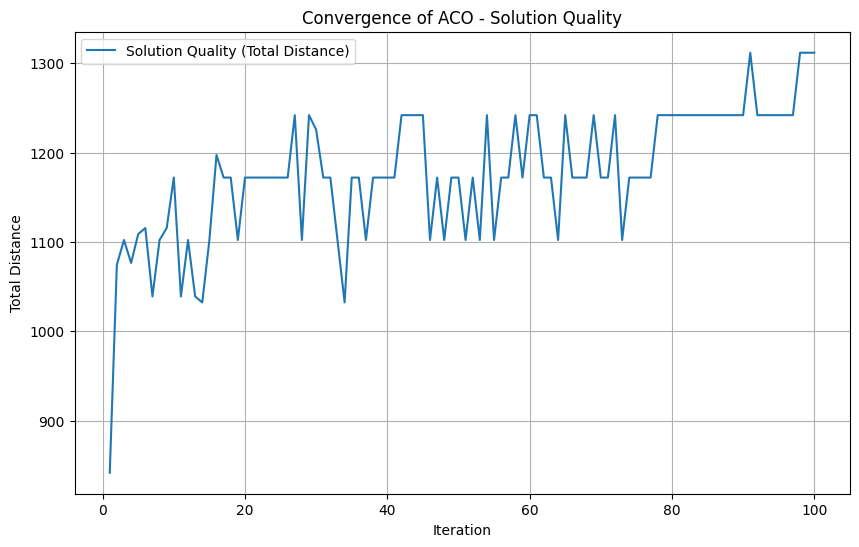

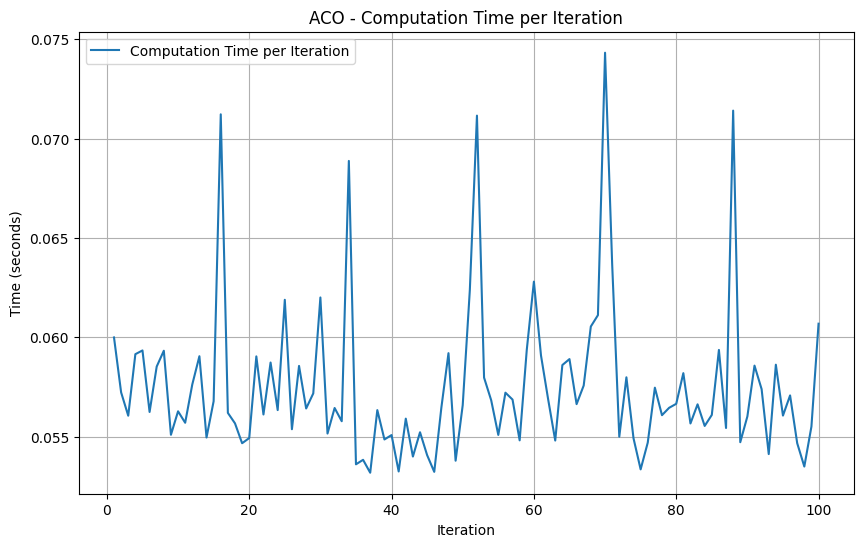

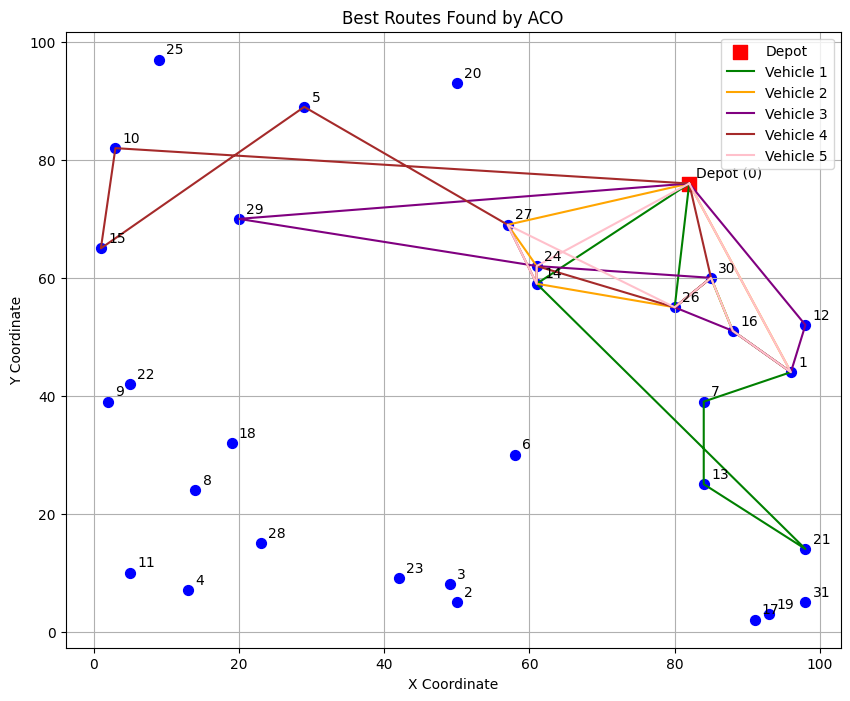

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time  # For measuring time

# ----------------- Flexible File Loading -----------------
def load_file(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)
    elif file_path.endswith('.vrp'):
        return load_vrp_data(file_path)
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

# ----------------- Custom VRP Parser -----------------
def load_vrp_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    coordinates = {}
    demands = {}
    depot = None
    vehicle_capacity = None

    node_section = False
    demand_section = False
    depot_section = False

    for line in lines:
        line = line.strip()

        if line.startswith("CAPACITY"):
            vehicle_capacity = int(line.split()[-1])
        elif line.startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        elif line.startswith("DEMAND_SECTION"):
            node_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            demand_section = False
            depot_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1
            x, y = float(parts[1]), float(parts[2])
            coordinates[customer_id] = (x, y)

        if demand_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1
            demand = int(parts[1])
            demands[customer_id] = demand

        if depot_section:
            depot_id = int(line)
            if depot_id != -1:
                depot = depot_id - 1

    return coordinates, demands, depot, vehicle_capacity

# ----------------- Problem Definition -----------------
file_path = '/content/sample_data/A-n32-k5.vrp'
data = load_file(file_path)

if isinstance(data, tuple):
    customers, demands, depot, vehicle_capacity = data
else:
    raise ValueError("Currently, only VRP file handling is implemented.")

# ----------------- ACO Functions -----------------

def calculate_distance_matrix(customers):
    num_customers = len(customers)
    distance_matrix = np.zeros((num_customers, num_customers))
    for i in customers:
        for j in customers:
            if i != j:
                xi, yi = customers[i]
                xj, yj = customers[j]
                distance = np.sqrt((xi - xj)**2 + (yi - yj)**2)
                distance_matrix[i][j] = distance
            else:
                distance_matrix[i][j] = 0
    return distance_matrix

def probability_of_next_node(pheromone, distance, alpha, beta):
    if distance == 0:
        return 0
    return (pheromone ** alpha) * ((1.0 / distance) ** beta)

def construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles):
    routes = []
    for _ in range(num_vehicles):
        route = [depot]
        vehicle_load = 0
        visited = set([depot])

        while True:
            current_node = route[-1]
            probabilities = []
            candidates = []
            for customer in customers:
                if customer not in visited and demands[customer] + vehicle_load <= vehicle_capacity:
                    candidates.append(customer)
                    prob = probability_of_next_node(
                        pheromone_matrix[current_node][customer],
                        distance_matrix[current_node][customer],
                        alpha,
                        beta
                    )
                    probabilities.append(prob)

            if not candidates:
                route.append(depot)
                break

            total = sum(probabilities)
            if total == 0:
                probabilities = [1/len(probabilities)] * len(probabilities)
            else:
                probabilities = [p / total for p in probabilities]

            next_customer = random.choices(candidates, weights=probabilities, k=1)[0]
            route.append(next_customer)
            vehicle_load += demands[next_customer]
            visited.add(next_customer)

        routes.append(route)

    return routes

def calculate_route_length(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

def update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant):
    pheromone_matrix *= (1 - evaporation_rate)

    for routes in ants_solutions:
        total_distance = 0
        for route in routes:
            total_distance += calculate_route_length(route, distance_matrix)
        pheromone_deposit = pheromone_constant / total_distance

        for route in routes:
            for i in range(len(route) - 1):
                pheromone_matrix[route[i]][route[i+1]] += pheromone_deposit
                pheromone_matrix[route[i+1]][route[i]] += pheromone_deposit  # Symmetric

# ----------------- Performance Metrics Collection -----------------

def run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant, num_iterations=100):
    distance_matrix = calculate_distance_matrix(customers)
    pheromone_matrix = np.ones((len(customers), len(customers)))

    best_routes = None
    best_distance = float('inf')

    distances = []  # To track solution quality (total distance) at each iteration
    times = []      # To track time taken for each iteration

    for iteration in range(num_iterations):
        start_time = time.time()  # Start timing the iteration
        ants_solutions = []
        iteration_best_distance = float('inf')
        iteration_best_routes = None

        for _ in range(num_ants):
            solution = construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles)
            ants_solutions.append(solution)

            total_distance = sum([calculate_route_length(route, distance_matrix) for route in solution])

            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = solution

            if total_distance < iteration_best_distance:
                iteration_best_distance = total_distance
                iteration_best_routes = solution

        update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant)

        end_time = time.time()  # End timing the iteration

        # Track metrics
        distances.append(iteration_best_distance)
        times.append(end_time - start_time)  # Time taken for this iteration

    return best_routes, best_distance, distances, times

# ----------------- Run the ACO Algorithm -----------------
num_ants = 30
alpha = 1.0
beta = 5.0
evaporation_rate = 0.5
pheromone_constant = 100
num_iterations = 100

best_routes, best_distance, distances, times = run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant)

# ----------------- Graphing the Results -----------------

# Plot the solution quality (convergence curve)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(distances) + 1), distances, label='Solution Quality (Total Distance)')
plt.xlabel('Iteration')
plt.ylabel('Total Distance')
plt.title('Convergence of ACO - Solution Quality')
plt.grid(True)
plt.legend()
plt.show()

# Plot the computational time per iteration
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(times) + 1), times, label='Computation Time per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('ACO - Computation Time per Iteration')
plt.grid(True)
plt.legend()
plt.show()

# Plot the best routes based on the best parameters
def plot_customers(customers, routes=None):
    plt.figure(figsize=(10, 8))
    for customer, (x, y) in customers.items():
        if customer == depot:
            plt.scatter(x, y, c='red', marker='s', s=100, label='Depot')
            plt.text(x + 1, y + 1, f'Depot ({customer})')
        else:
            plt.scatter(x, y, c='blue', marker='o', s=50)
            plt.text(x + 1, y + 1, f'{customer}')

    if routes:
        colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray']
        for idx, route in enumerate(routes):
            route_coords = [customers[customer] for customer in route]
            xs, ys = zip(*route_coords)
            plt.plot(xs, ys, color=colors[idx % len(colors)], label=f'Vehicle {idx+1}')

    plt.title('Best Routes Found by ACO')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_customers(customers, best_routes)


Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.1, pheromone_constant=50
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.1, pheromone_constant=100
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.1, pheromone_constant=150
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.3, pheromone_constant=50
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.3, pheromone_constant=100
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.3, pheromone_constant=150
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.5, pheromone_constant=50
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.5, pheromone_constant=100
Testing ACO with: num_ants=10, alpha=0.5, beta=2.0, evaporation_rate=0.5, pheromone_constant=150
Testing ACO with: num_ants=10, alpha=0.5, beta=5.0, evaporation_rate=0.1, pheromone_constant=50
Testing ACO with: num_ants=10, alp

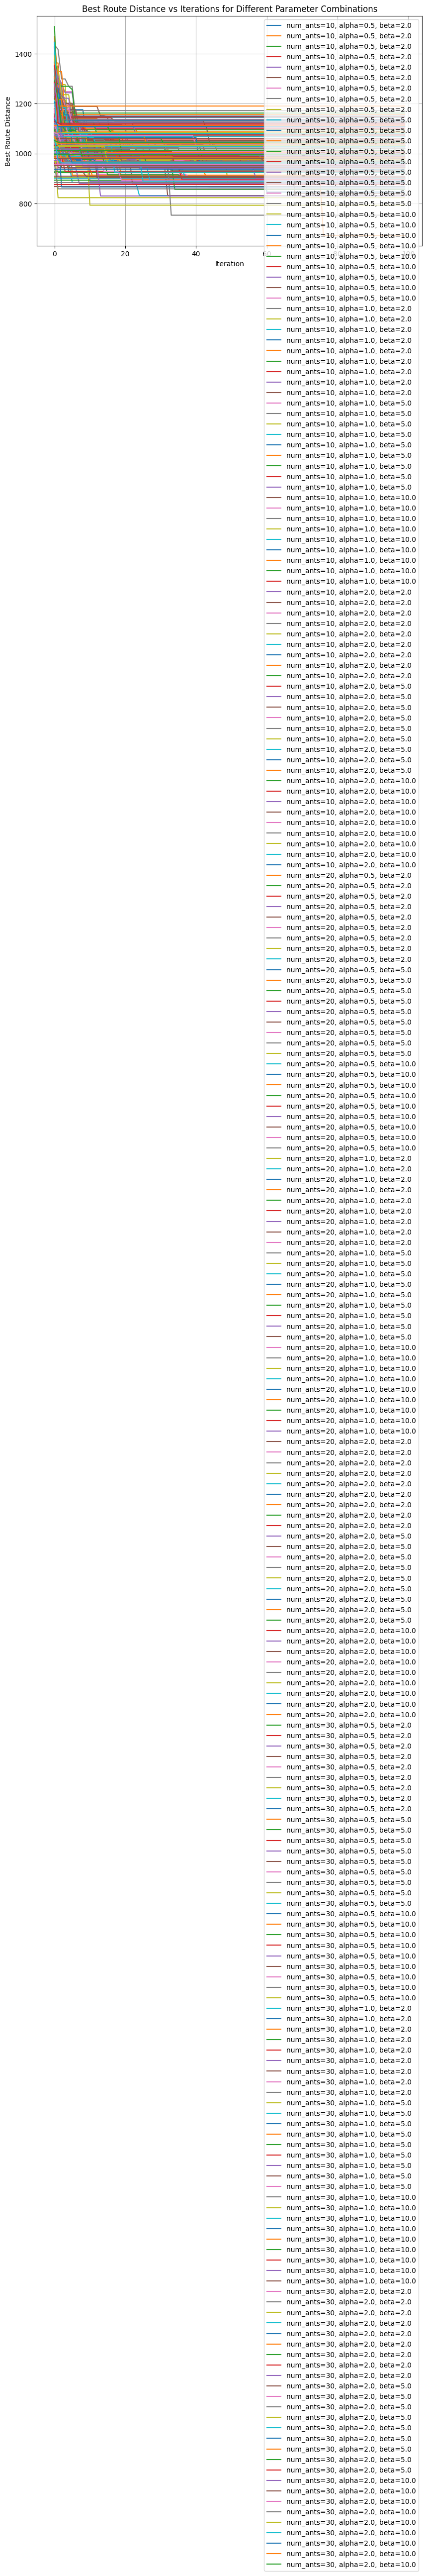

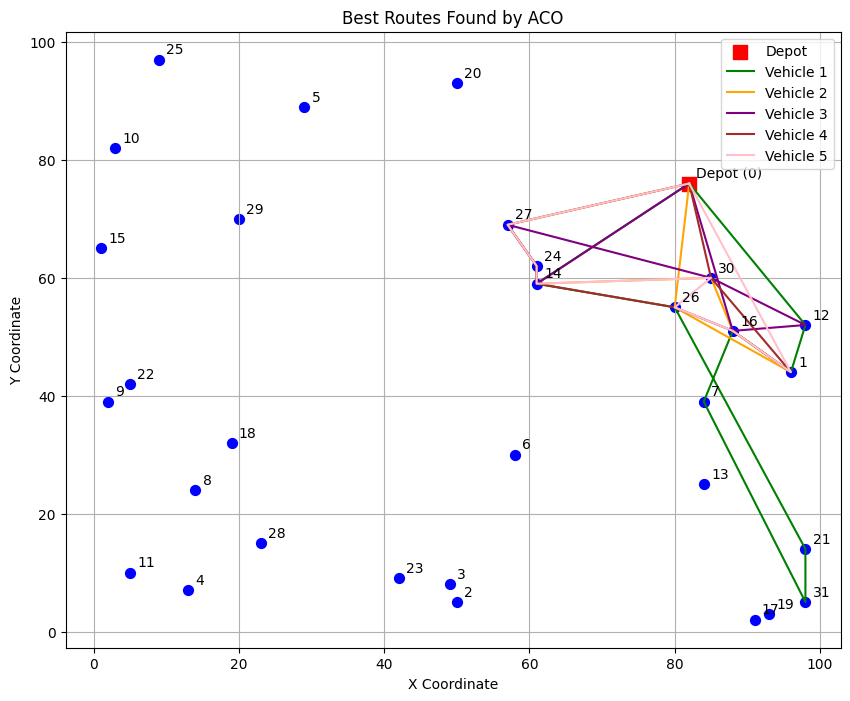

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from itertools import product

# ----------------- Flexible File Loading -----------------

def load_file(file_path):
    if file_path.endswith('.csv'):
        return pd.read_csv(file_path)  # Uses Pandas for CSV
    elif file_path.endswith('.xlsx'):
        return pd.read_excel(file_path)  # Uses Pandas for Excel
    elif file_path.endswith('.json'):
        return pd.read_json(file_path)  # Uses Pandas for JSON
    elif file_path.endswith('.vrp'):
        return load_vrp_data(file_path)  # Uses custom parser for VRP
    else:
        raise ValueError(f"Unsupported file type: {file_path}")

# ----------------- Custom VRP Parser -----------------

def load_vrp_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    coordinates = {}
    demands = {}
    depot = None
    vehicle_capacity = None

    node_section = False
    demand_section = False
    depot_section = False

    for line in lines:
        line = line.strip()

        if line.startswith("CAPACITY"):
            vehicle_capacity = int(line.split()[-1])
        elif line.startswith("NODE_COORD_SECTION"):
            node_section = True
            continue
        elif line.startswith("DEMAND_SECTION"):
            node_section = False
            demand_section = True
            continue
        elif line.startswith("DEPOT_SECTION"):
            demand_section = False
            depot_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            x, y = float(parts[1]), float(parts[2])
            coordinates[customer_id] = (x, y)

        if demand_section:
            parts = line.split()
            customer_id = int(parts[0]) - 1  # Convert to 0-based index
            demand = int(parts[1])
            demands[customer_id] = demand

        if depot_section:
            depot_id = int(line)
            if depot_id != -1:
                depot = depot_id - 1  # Convert to 0-based index

    return coordinates, demands, depot, vehicle_capacity

# ----------------- Problem Definition -----------------

# Load the dataset (can handle CSV, Excel, JSON, or VRP files)
file_path = '/content/sample_data/A-n32-k5.vrp'
data = load_file(file_path)

# If using a VRP file, it returns the necessary components
if isinstance(data, tuple):
    customers, demands, depot, vehicle_capacity = data
else:
    raise ValueError("Currently, only VRP file handling is implemented.")

# ----------------- ACO Functions -----------------

def probability_of_next_node(pheromone, distance, alpha, beta):
    if distance == 0:
        return 0
    return (pheromone ** alpha) * ((1.0 / distance) ** beta)

def construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles):
    routes = []
    for _ in range(num_vehicles):
        route = [depot]  # Start from depot
        vehicle_load = 0
        visited = set([depot])

        while True:
            current_node = route[-1]
            probabilities = []
            candidates = []
            for customer in customers:
                if customer not in visited and demands[customer] + vehicle_load <= vehicle_capacity:
                    candidates.append(customer)
                    prob = probability_of_next_node(
                        pheromone_matrix[current_node][customer],
                        distance_matrix[current_node][customer],
                        alpha,
                        beta
                    )
                    probabilities.append(prob)

            if not candidates:
                # No more customers can be added to this route
                route.append(depot)  # Return to depot
                break

            # Normalize probabilities
            total = sum(probabilities)
            if total == 0:
                # Avoid division by zero
                probabilities = [1/len(probabilities)] * len(probabilities)
            else:
                probabilities = [p / total for p in probabilities]

            # Select next customer based on probability distribution
            next_customer = random.choices(candidates, weights=probabilities, k=1)[0]
            route.append(next_customer)
            vehicle_load += demands[next_customer]
            visited.add(next_customer)

        routes.append(route)

    # Check if all customers are visited
    all_visited = True
    for customer in customers:
        if customer not in [c for route in routes for c in route]:
            all_visited = False
            break

    if not all_visited:
        # If not all customers are visited, assign remaining to any vehicle that can take them
        for customer in customers:
            if customer not in [c for route in routes for c in route]:
                for route in routes:
                    # Check capacity
                    current_load = sum([demands[c] for c in route if c != depot])
                    if current_load + demands[customer] <= vehicle_capacity:
                        # Insert before returning to depot
                        route.insert(-1, customer)
                        break

    return routes

def calculate_route_length(route, distance_matrix):
    return sum(distance_matrix[route[i]][route[i+1]] for i in range(len(route) - 1))

def update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant):
    # Evaporate pheromones
    pheromone_matrix *= (1 - evaporation_rate)

    # Add pheromones based on solutions
    for routes in ants_solutions:
        total_distance = 0
        for route in routes:
            total_distance += calculate_route_length(route, distance_matrix)
        pheromone_deposit = pheromone_constant / total_distance

        for route in routes:
            for i in range(len(route) - 1):
                pheromone_matrix[route[i]][route[i+1]] += pheromone_deposit
                pheromone_matrix[route[i+1]][route[i]] += pheromone_deposit  # Symmetric

# ----------------- Grid Search for Parameter Tuning -----------------

def run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant, num_iterations=100):
    num_customers = len(customers)
    pheromone_matrix = np.ones((num_customers, num_customers))  # Initial pheromone

    best_routes = None
    best_distance = float('inf')

    # ADDED: List to store the best distance at each iteration
    best_distances_over_iterations = []

    for iteration in range(num_iterations):
        ants_solutions = []
        iteration_best_distance = float('inf')

        for _ in range(num_ants):
            solution = construct_solution(pheromone_matrix, distance_matrix, demands, vehicle_capacity, num_vehicles)
            ants_solutions.append(solution)

            total_distance = sum([calculate_route_length(route, distance_matrix) for route in solution])

            if total_distance < best_distance:
                best_distance = total_distance
                best_routes = solution

            if total_distance < iteration_best_distance:
                iteration_best_distance = total_distance

        update_pheromones(pheromone_matrix, ants_solutions, distance_matrix, evaporation_rate, pheromone_constant)

        # ADDED: Append the best distance found in this iteration
        best_distances_over_iterations.append(best_distance)

    return best_distance, best_routes, best_distances_over_iterations  # Return the best distance, routes, and distance progression

# Define parameter ranges for grid search
param_grid = {
    'num_ants': [10, 20, 30],
    'alpha': [0.5, 1.0, 2.0],
    'beta': [2.0, 5.0, 10.0],
    'evaporation_rate': [0.1, 0.3, 0.5],
    'pheromone_constant': [50, 100, 150]
}

# Get all combinations of parameters
param_combinations = list(product(param_grid['num_ants'],
                                  param_grid['alpha'],
                                  param_grid['beta'],
                                  param_grid['evaporation_rate'],
                                  param_grid['pheromone_constant']))

# Initialize variables to store the best parameters and results
best_params = None
best_distance = float('inf')
best_routes_final = None  # ADDED: Store best routes for plotting

# ADDED: For storing the best distances for plotting later
best_distances_to_plot = []

# Run ACO for each combination of parameters
for (num_ants, alpha, beta, evaporation_rate, pheromone_constant) in param_combinations:
    print(f"Testing ACO with: num_ants={num_ants}, alpha={alpha}, beta={beta}, evaporation_rate={evaporation_rate}, pheromone_constant={pheromone_constant}")

    # Run ACO and get the best distance, best routes, and distance progression
    distance, best_routes, best_distances_over_iterations = run_aco(num_ants, alpha, beta, evaporation_rate, pheromone_constant)

    # Save the distances to plot later
    best_distances_to_plot.append((num_ants, alpha, beta, best_distances_over_iterations))

    # Check if this is the best result so far
    if distance < best_distance:
        best_distance = distance
        best_params = (num_ants, alpha, beta, evaporation_rate, pheromone_constant)
        best_routes_final = best_routes  # Store the best routes for final plotting

print(f"Best parameters: {best_params}")
print(f"Best total distance: {best_distance}")

# ----------------- Plotting the Best Routes over Iterations -----------------

plt.figure(figsize=(10, 6))

# Plot the best route distance over iterations for different parameter combinations
for (num_ants, alpha, beta, best_distances_over_iterations) in best_distances_to_plot:
    plt.plot(best_distances_over_iterations, label=f'num_ants={num_ants}, alpha={alpha}, beta={beta}')

plt.title('Best Route Distance vs Iterations for Different Parameter Combinations')
plt.xlabel('Iteration')
plt.ylabel('Best Route Distance')
plt.legend()
plt.grid(True)
plt.show()

# ----------------- Plotting the Best Routes Geographically (Your Implementation) -----------------

# Plot the best routes based on the best parameters
def plot_customers(customers, routes=None):
    plt.figure(figsize=(10, 8))
    for customer, (x, y) in customers.items():
        if customer == depot:
            plt.scatter(x, y, c='red', marker='s', s=100, label='Depot')
            plt.text(x + 1, y + 1, f'Depot ({customer})')
        else:
            plt.scatter(x, y, c='blue', marker='o', s=50)
            plt.text(x + 1, y + 1, f'{customer}')

    if routes:
        colors = ['green', 'orange', 'purple', 'brown', 'pink', 'gray']
        for idx, route in enumerate(routes):
            route_coords = [customers[customer] for customer in route]
            xs, ys = zip(*route_coords)
            plt.plot(xs, ys, color=colors[idx % len(colors)], label=f'Vehicle {idx+1}')

    plt.title('Best Routes Found by ACO')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the best routes
plot_customers(customers, best_routes_final)